In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib as mlp
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv("C:\\Users\\thoma\\Desktop\\ev-modelling-repo\\Data\\NHTS_trips_processed.csv")

In [3]:
filt = df["ST_WOTAG"] < 6
df = df[filt]

# Nur 1. Weg und dessen Startzeit relevant

### Achtung: W_NR (Weg Nummer) scheinbar nicht explizit in MiD Studie -> Ermittlung dort auf andere Art und Weise

In [4]:
filt = df["W_NR"] == 1
first_trip = df[filt]["W_SZ_MIN"]

In [5]:
first_trip.value_counts()

450     8579
480     7588
420     7445
540     6373
600     6190
        ... 
1303       1
1351       1
1257       1
1224       1
1317       1
Name: W_SZ_MIN, Length: 1035, dtype: int64

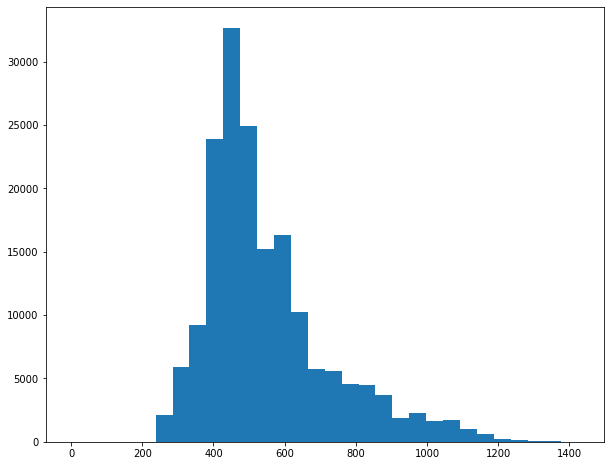

In [6]:
plt.figure(figsize=(10,8))
count, bins, ignored = plt.hist(first_trip, bins = 30 )

# Gaussian Mixture Model ermitteln

In [7]:
from sklearn.mixture import GaussianMixture

In [8]:
model_data = np.array(first_trip)

In [9]:
gm_models = [None for i in range(15)]
model_data = np.array(first_trip).reshape(-1,1)
for i in range(1, 16):
    gm_models[i-1] = GaussianMixture(n_components=i, n_init=10).fit(model_data)
    

## Bestimme bestes Model anhand 'theoretical information criterion' 
* je kleiner desto besser
* Bestrafung komplexerer Systeme (mehr Komponenten)
* Belohnung besserer fit zu den Daten


In [10]:
AIC = [m.aic(model_data) for m in gm_models]
BIC = [m.bic(model_data) for m in gm_models]

In [11]:
m_best = gm_models[np.argmin(AIC)]

# Ergebnis plotten

* logprob = logarithmische Wahrscheinlichkeit der x-Werte 
* responsibilities = Anteil der individuellen Normalverteilungen an der Gesamtwahrscheinlichkeit

In [12]:
x = np.linspace(-50, 1450, 10000)
logprob = m_best.score_samples(x.reshape(-1, 1))
responsibilities = m_best.predict_proba(x.reshape(-1, 1))
pdf = np.exp(logprob)
pdf_individual = responsibilities * pdf[:, np.newaxis]

Text(0, 0.5, 'relative Wahrscheinlichkeit')

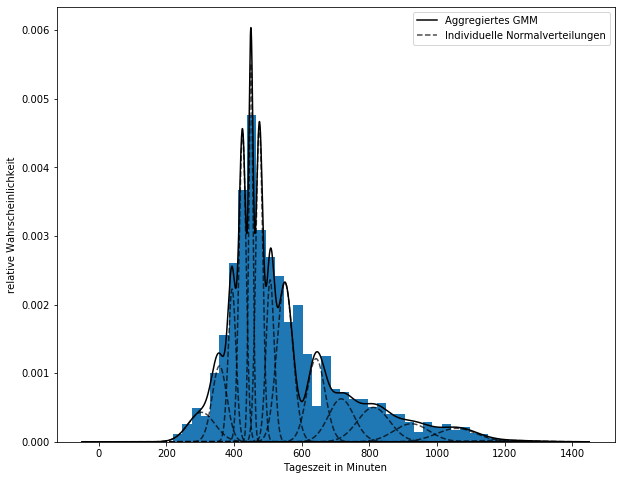

In [13]:
plt.figure(figsize=(10,8))
plt.hist(first_trip, bins=52, density=True);
plt.plot(x, pdf, '-k');
plt.plot(x, pdf_individual, '--k', alpha=0.7);
labels = ["Aggregiertes GMM", "Individuelle Normalverteilungen"]
plt.legend(labels)
plt.xlabel("Tageszeit in Minuten")
plt.ylabel("relative Wahrscheinlichkeit")

# Alternative: Kernel Density Estimation

In [9]:
from sklearn.neighbors import KernelDensity

In [40]:
x = np.linspace(-50, 1450, 1000)
model_data = np.array(first_trip)

In [43]:
# Erstellen Kernel Density Estimation Modell mit Bandbreite 12
kde_model = KernelDensity(bandwidth=12)
kde_model.fit(model_data[:, np.newaxis])
# übertragen in visaulisierbare Wahrscheinlichkeitsdichtefunktion
kde_log_pdf = kde_model.score_samples(x[:, np.newaxis])
kde_pdf = np.exp(kde_log_pdf)

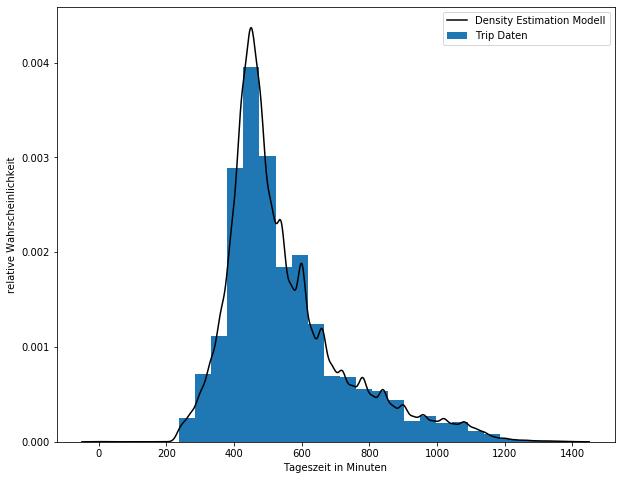

In [52]:
plt.figure(figsize=(10,8))
plt.hist(first_trip, bins=30, density=True);
plt.plot(x, kde_pdf, '-k');
labels = ["Density Estimation Modell", "Trip Daten"]
plt.legend(labels);
plt.xlabel("Tageszeit in Minuten");
plt.ylabel("relative Wahrscheinlichkeit");

In [ ]:
# Optimierung der Bandweite -> lange Rechenzeit
"""from sklearn.model_selection import GridSearchCV
grid = GridSearchCV(KernelDensity(),
                    {'bandwidth': np.linspace(10, 15, 5)},
                    cv=5) # 20-fold cross-validation
grid.fit(model_data[:, None])
print(grid.best_params_)"""

## Testen des Modells

In [48]:
model_samples = kde_model.sample(len(model_data))

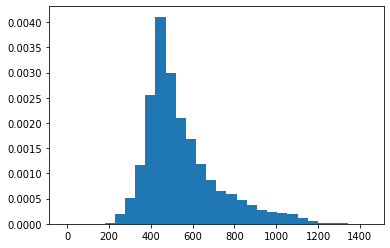

In [51]:
plt.figure();
plt.hist(model_samples, density=True, bins=30);

## Modell speichern

In [76]:
from pathlib import Path
import pickle
import os

root = os.getcwd()
if not os.path.exists(os.getcwd()+ "\\Ergebnisse"):
    os.makedirs(root+"\\Ergebnisse")

path = root+"\\Ergebnisse"+"\\Modell_Initiale_Abfahrtszeit_Werktag.pickle"

pickle.dump(kde_model, open(path, "wb"))